In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [72]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [73]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [74]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200402,AK,143.0,4879.0,NaN,NaN,9.0,NaN,NaN,NaN,...,9.0,5022,5022,5022,02,0.0,0.0,409.0,10.0,419.0
1,20200402,AL,1233.0,7503.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8736,8736,8736,01,6.0,0.0,806.0,156.0,962.0
2,20200402,AR,643.0,7880.0,NaN,66.0,NaN,NaN,NaN,23.0,...,NaN,8523,8523,8523,05,2.0,0.0,526.0,59.0,585.0
3,20200402,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200402,AZ,1598.0,21111.0,NaN,NaN,228.0,NaN,83.0,NaN,...,228.0,22709,22709,22709,04,3.0,79.0,1466.0,185.0,1651.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,50,32,32,41,NaN,NaN,NaN,NaN,NaN
1537,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,5,5,45,NaN,NaN,NaN,NaN,NaN
1538,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,48,NaN,NaN,NaN,NaN,NaN
1539,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,39,39,53,NaN,NaN,NaN,NaN,NaN


In [75]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [76]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [77]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [78]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [79]:
tests_df.groupby('Date')['completed'].sum().max()

1267658.0

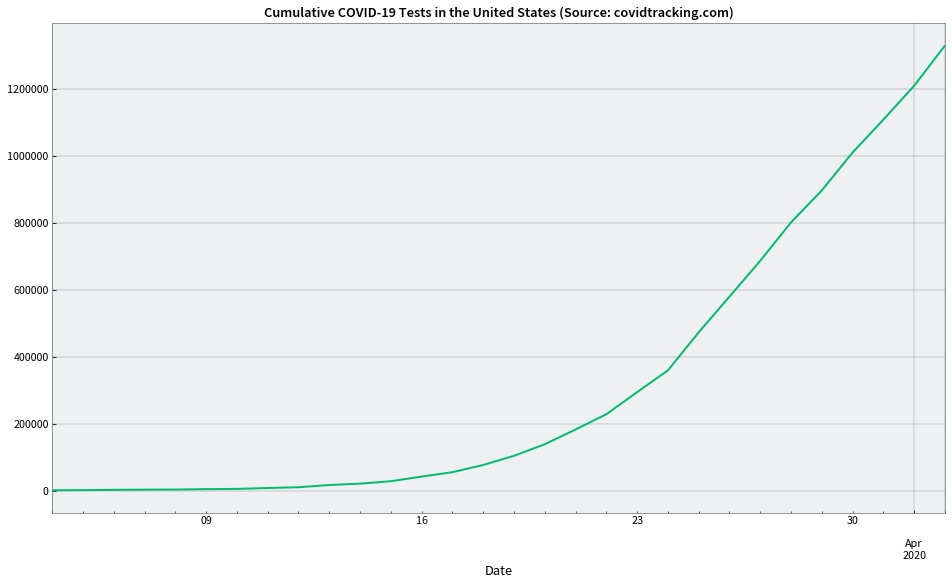

In [80]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

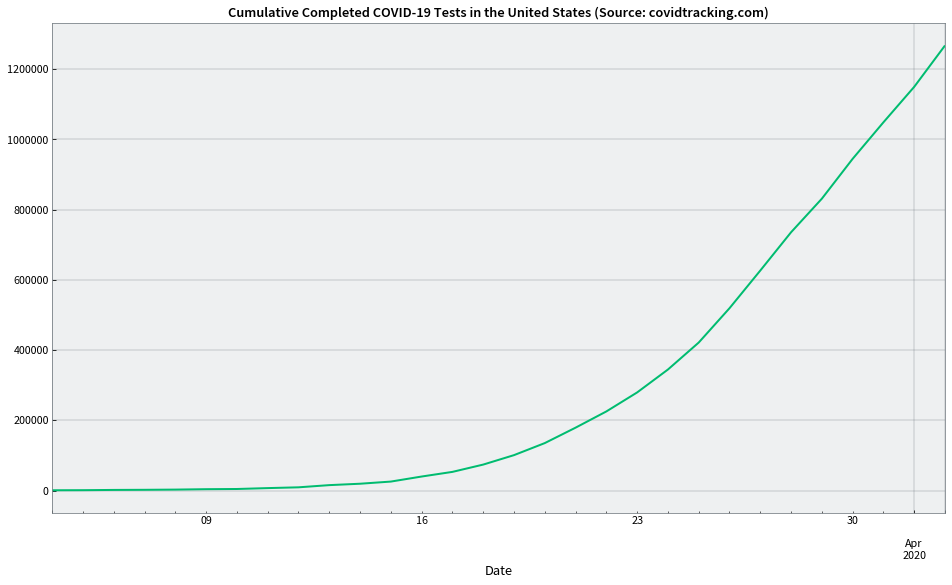

In [81]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

In [82]:
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Date,completed
0,20200402,AK,143.0,4879.0,NaN,NaN,9.0,NaN,NaN,NaN,...,5022,5022,02,0.0,0.0,409.0,10.0,419.0,2020-04-02,5022.0
1,20200402,AL,1233.0,7503.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8736,8736,01,6.0,0.0,806.0,156.0,962.0,2020-04-02,8736.0
2,20200402,AR,643.0,7880.0,NaN,66.0,NaN,NaN,NaN,23.0,...,8523,8523,05,2.0,0.0,526.0,59.0,585.0,2020-04-02,8523.0
3,20200402,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,20,20,60,0.0,0.0,0.0,0.0,0.0,2020-04-02,20.0
4,20200402,AZ,1598.0,21111.0,NaN,NaN,228.0,NaN,83.0,NaN,...,22709,22709,04,3.0,79.0,1466.0,185.0,1651.0,2020-04-02,22709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,32,32,41,NaN,NaN,NaN,NaN,NaN,2020-03-04,32.0
1537,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,5,5,45,NaN,NaN,NaN,NaN,NaN,2020-03-04,5.0
1538,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,48,NaN,NaN,NaN,NaN,NaN,2020-03-04,NaN
1539,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39,39,53,NaN,NaN,NaN,NaN,NaN,2020-03-04,NaN


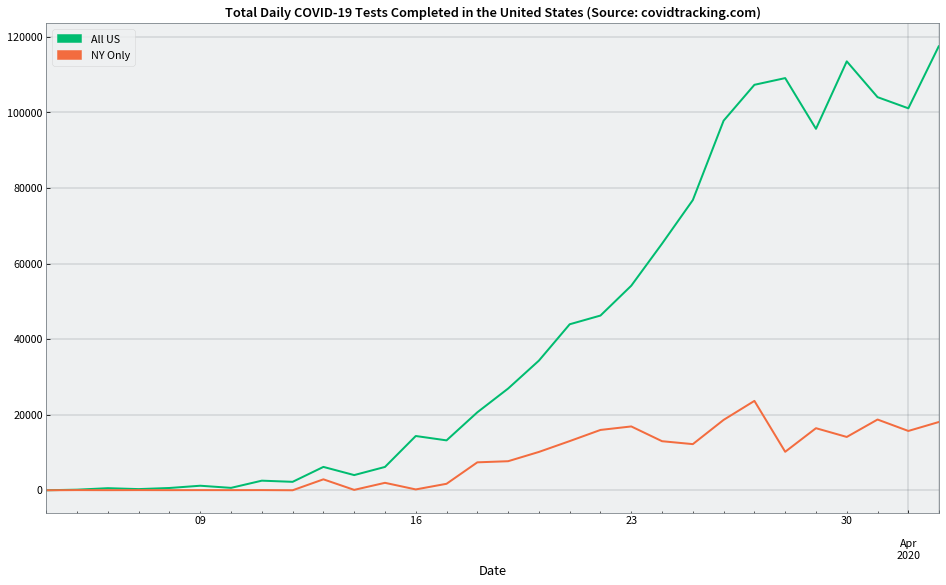

In [83]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [84]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

103571.5

In [85]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

16067.6

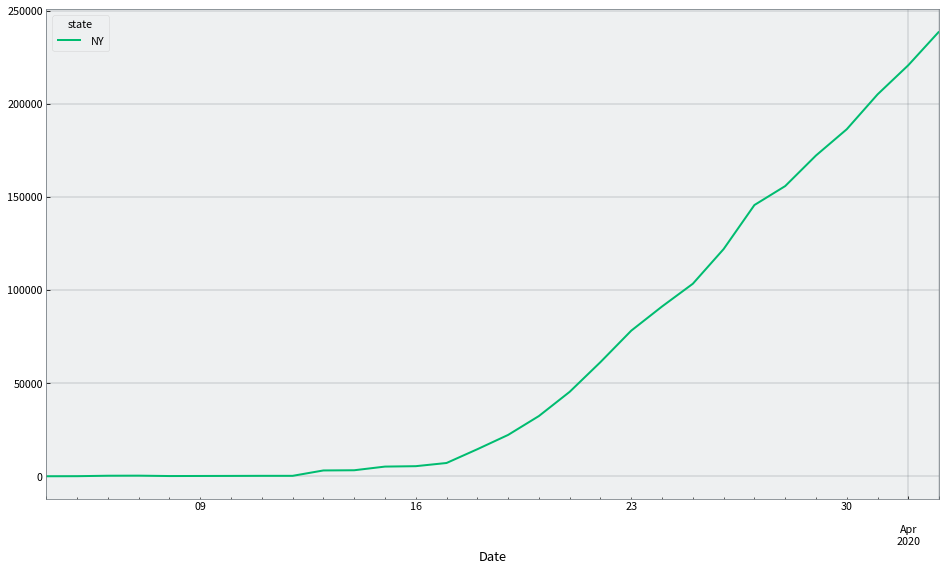

In [86]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

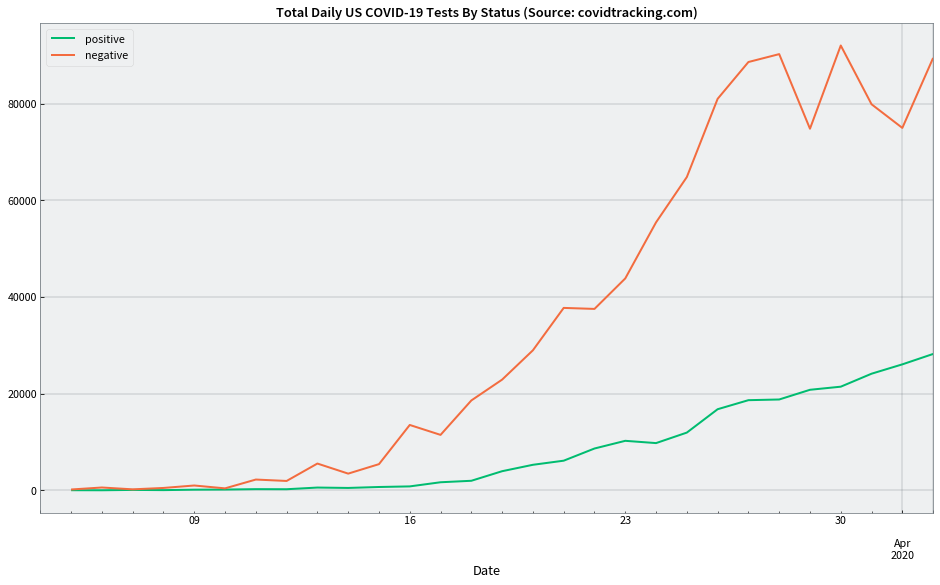

In [87]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

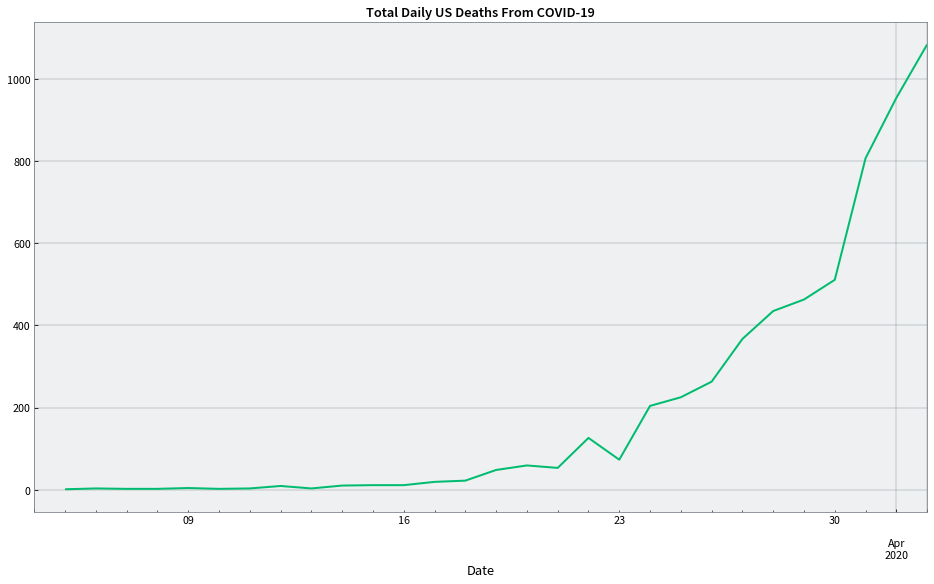

In [88]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

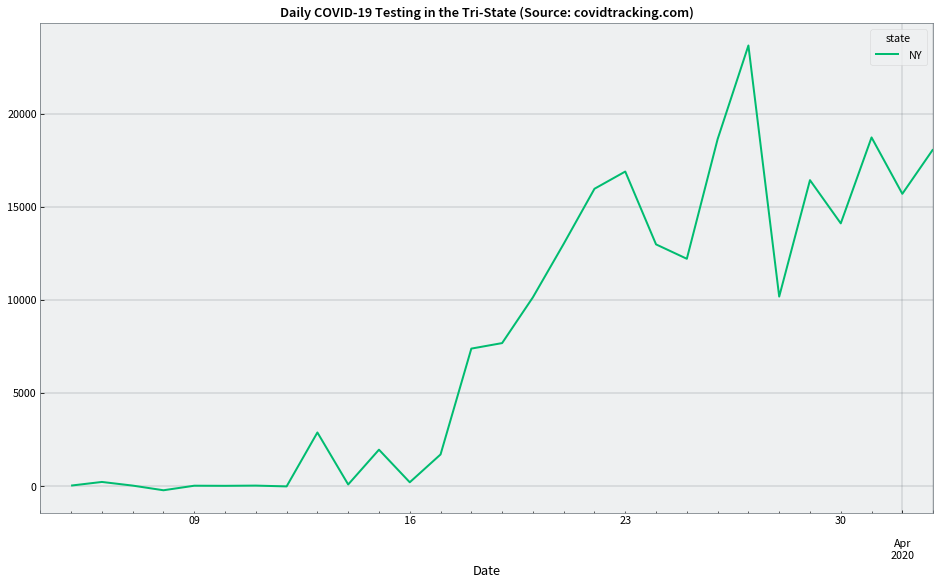

In [89]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

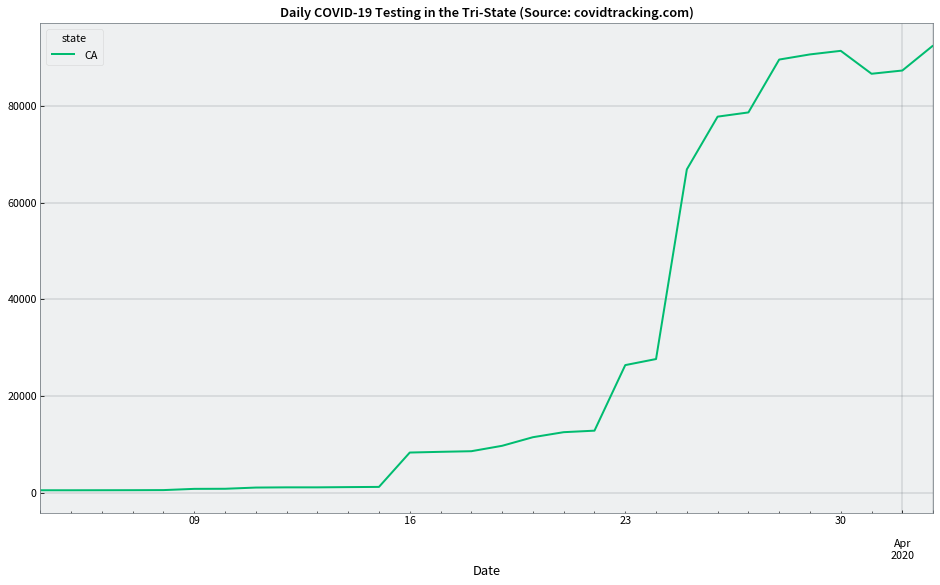

In [90]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

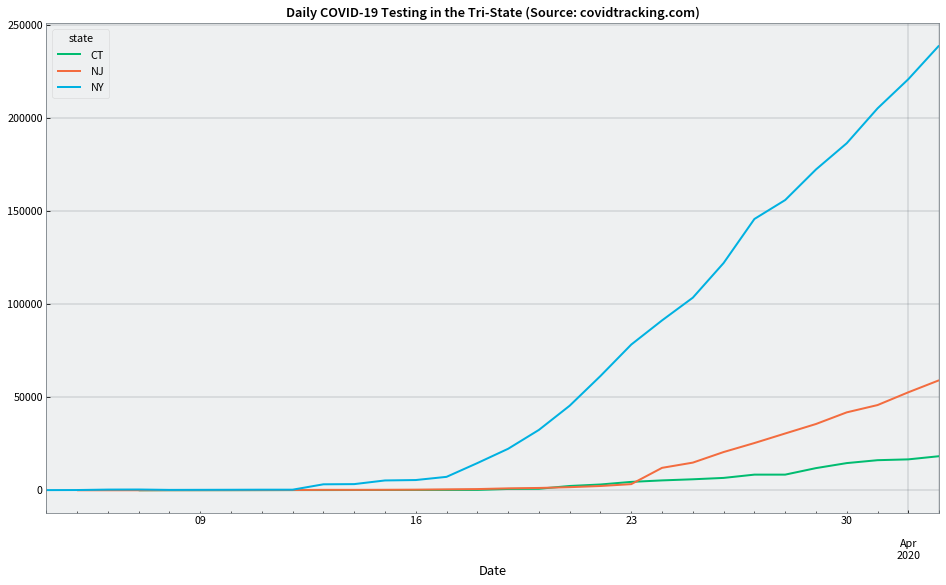

In [91]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

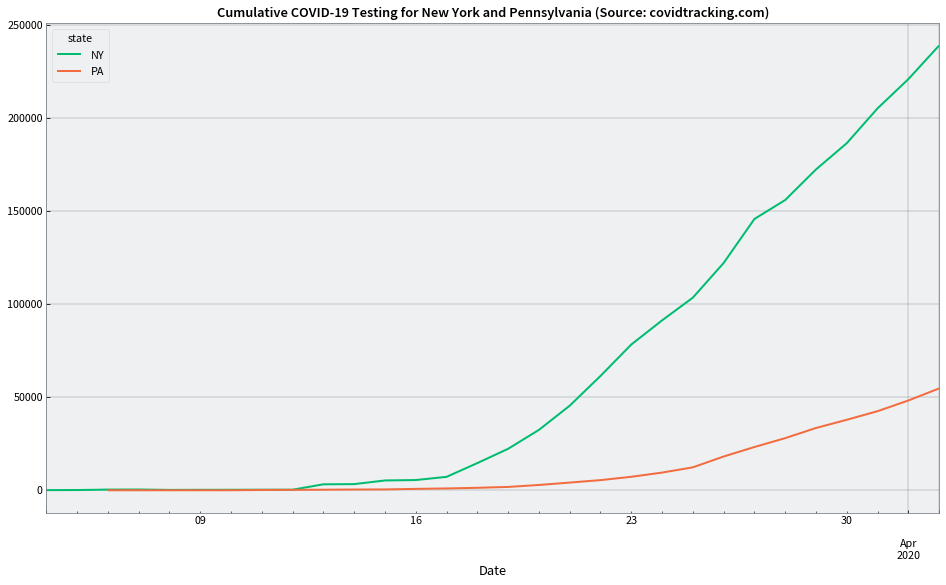

In [92]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

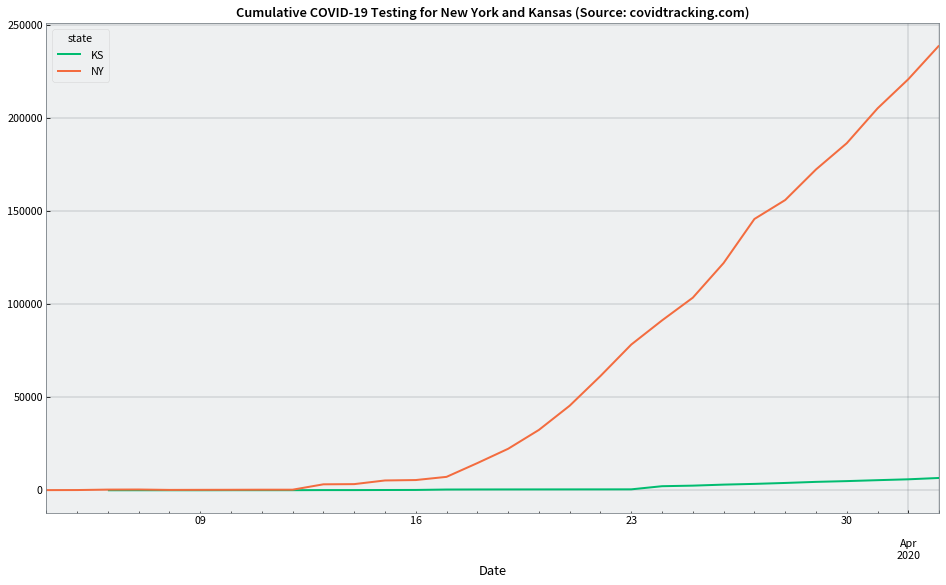

In [93]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

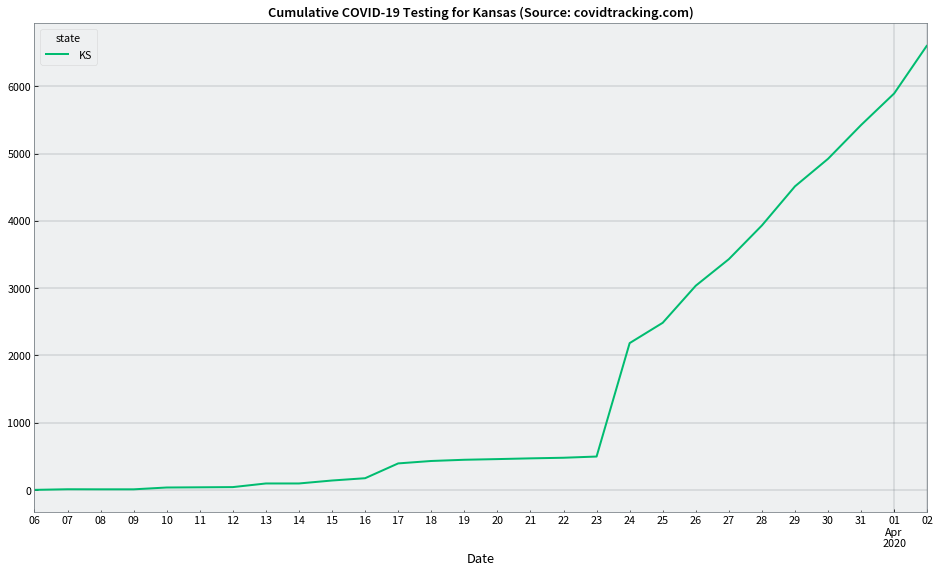

In [94]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [95]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

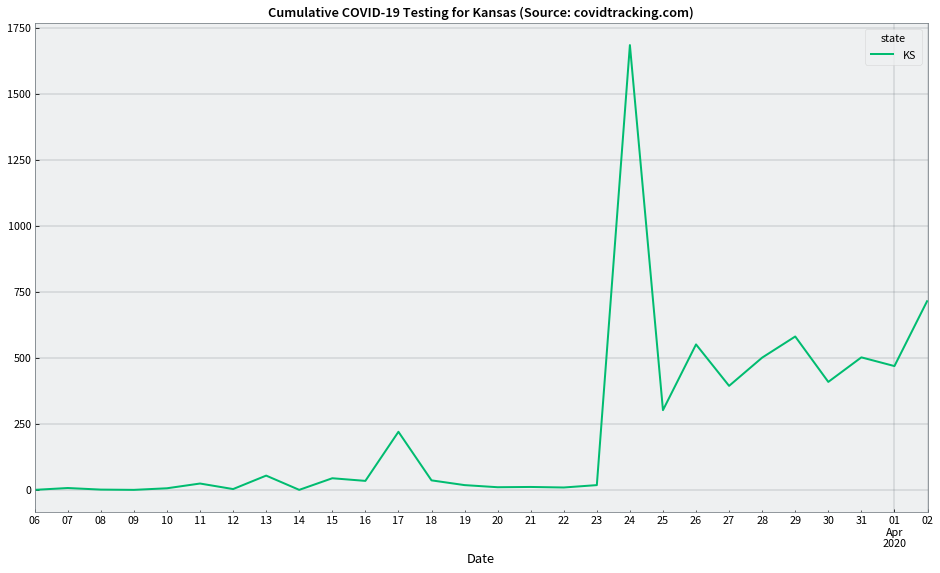

In [96]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

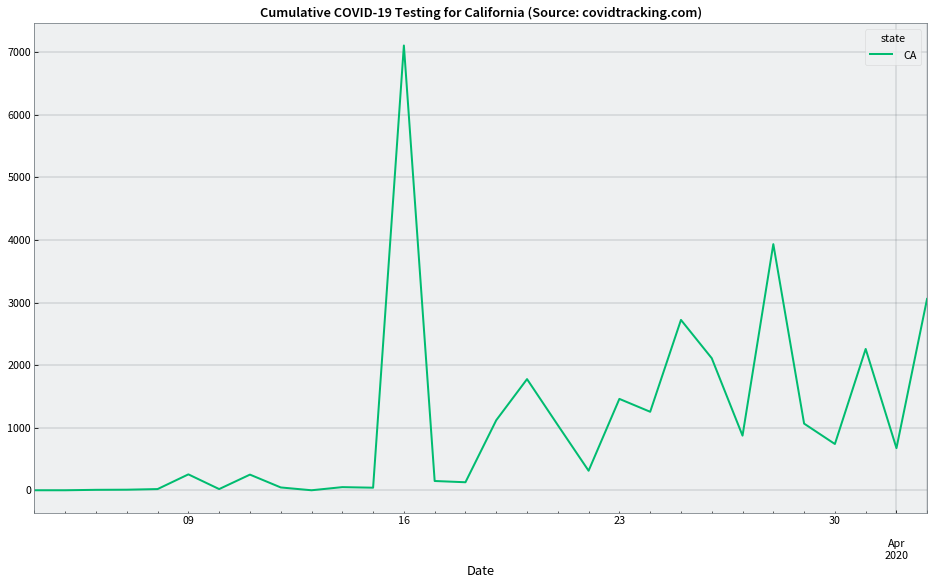

In [97]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

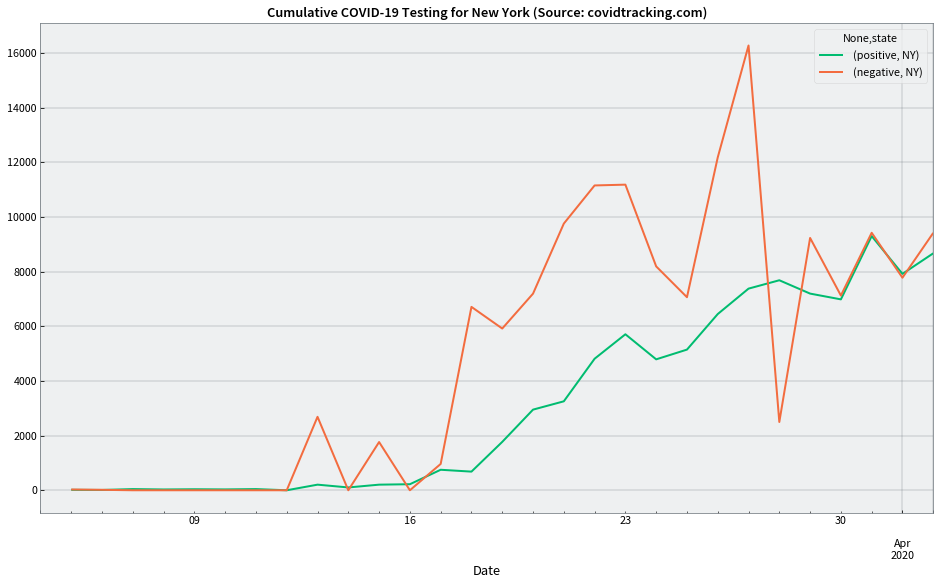

In [98]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [99]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [100]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
dtype: float64

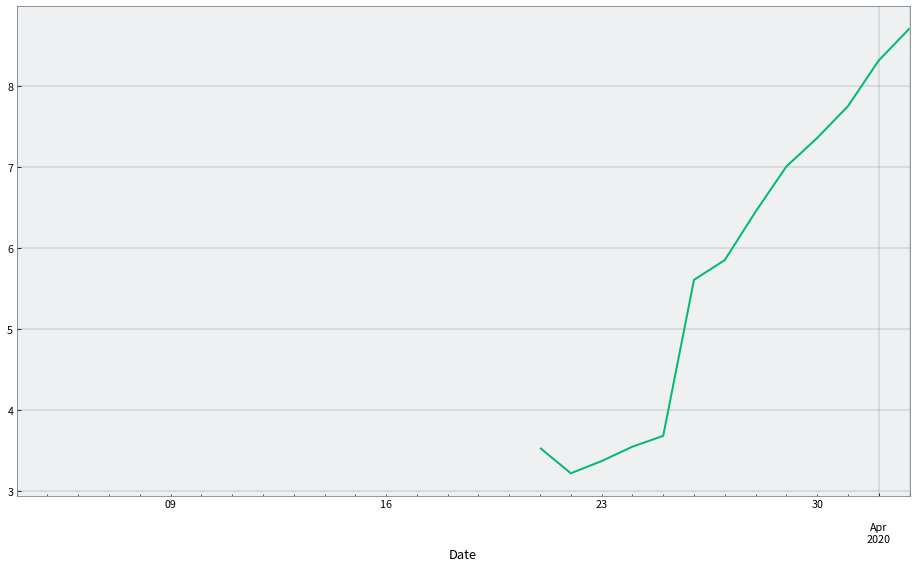

In [101]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

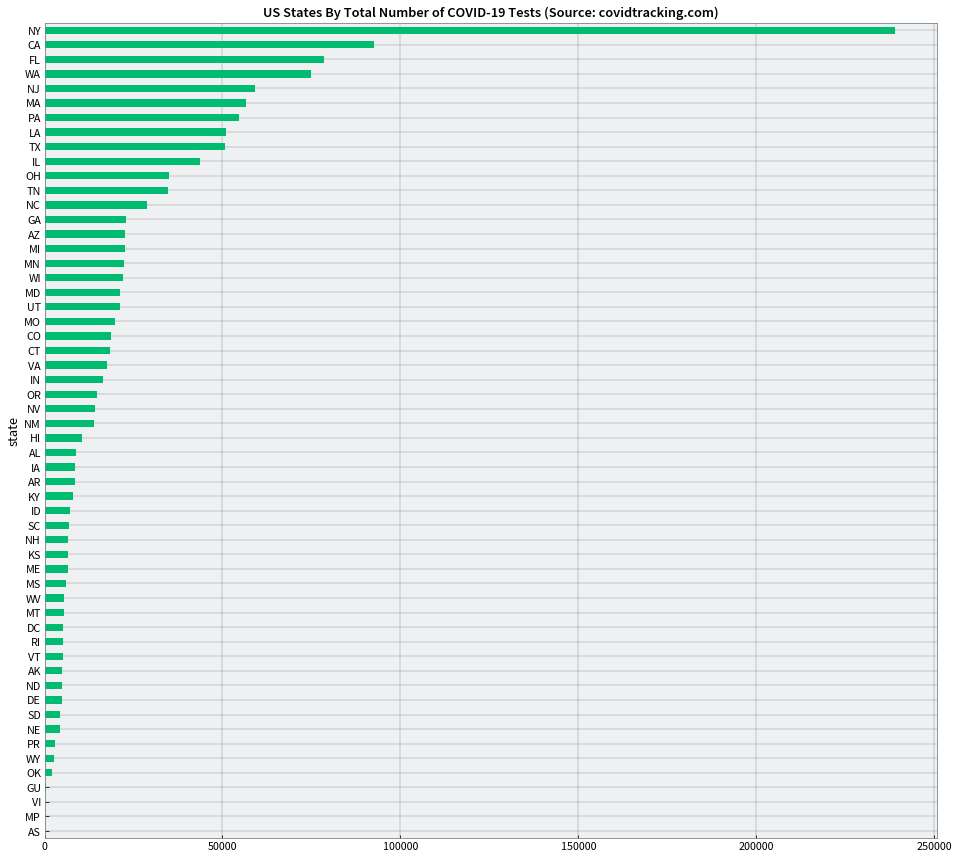

In [102]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [103]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.818182
MP        1.909091
VI       16.000000
GU       33.727273
OK      128.000000
PR      155.818182
WY      193.363636
SD      329.181818
ND      335.636364
NE      347.272727
VT      353.727273
DC      365.000000
RI      368.545455
AK      368.545455
ME      373.727273
MT      376.636364
MS      419.000000
DE      442.454545
WV      463.272727
NH      476.363636
SC      484.909091
ID      551.363636
KS      557.272727
KY      575.363636
AL      648.545455
IA      669.363636
AR      695.181818
NM      839.272727
HI      923.000000
NV     1037.090909
OR     1076.636364
CO     1281.363636
VA     1295.636364
IN     1344.636364
CT     1381.818182
WI     1402.909091
UT     1579.636364
MN     1610.363636
GA     1721.545455
MO     1747.636364
MI     1780.000000
CA     1832.727273
MD     1898.454545
NC     2021.909091
AZ     2025.000000
TN     2803.090909
OH     3129.727273
IL     3212.363636
TX     3811.181818
LA     4326.181818
WA     4334.272727
PA     4479.181818
MA    

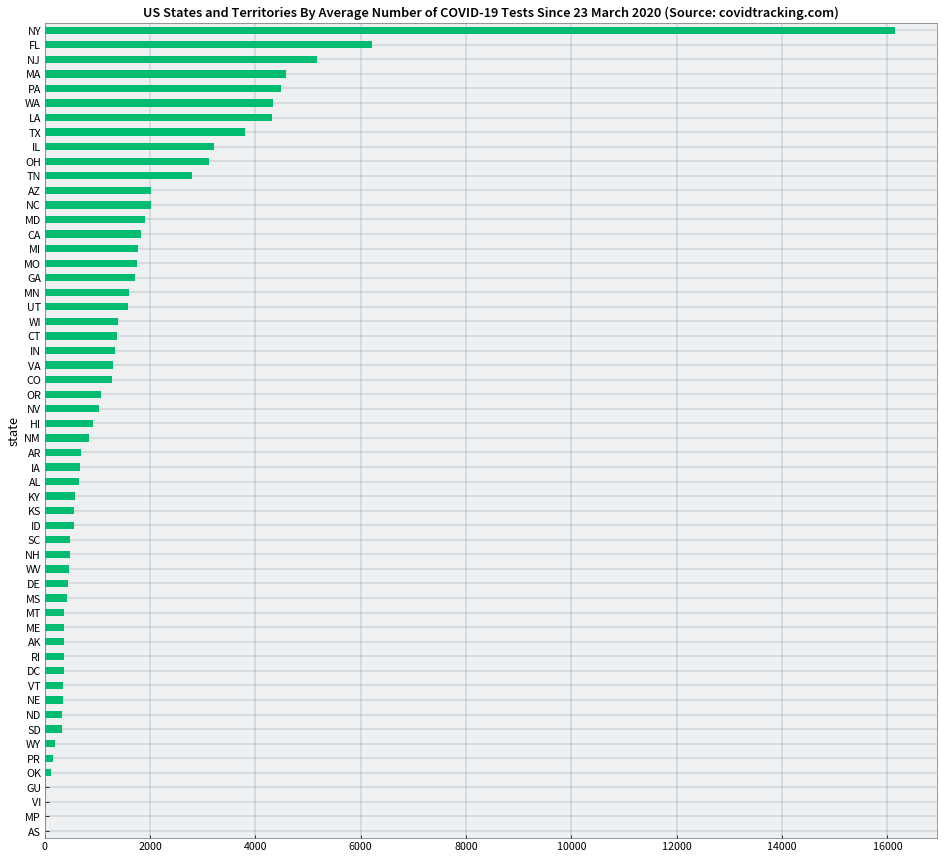

In [104]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [105]:
tests_df.groupby('state')['total'].max().sort_values()

state
AS        26
MP        33
VI       224
GU       524
OK      2144
WY      2589
PR      3039
NE      4235
SD      4382
DE      4959
ND      4980
AK      5022
VT      5049
RI      5069
DC      5070
MT      5320
WV      5493
MS      5930
ME      6464
KS      6611
NH      6619
SC      6995
ID      7282
KY      7900
AR      8523
IA      8668
AL      8736
HI     10464
NM     14011
NV     14046
OR     14868
IN     16285
VA     17589
CT     18300
CO     18645
MO     19683
UT     21167
MD     21221
WI     22047
MN     22394
MI     22684
AZ     22709
GA     22957
NC     28679
TN     34611
OH     34918
IL     43656
TX     50679
LA     51086
PA     54714
MA     56608
NJ     59110
WA     74798
FL     78581
CA     92500
NY    238965
Name: total, dtype: int64

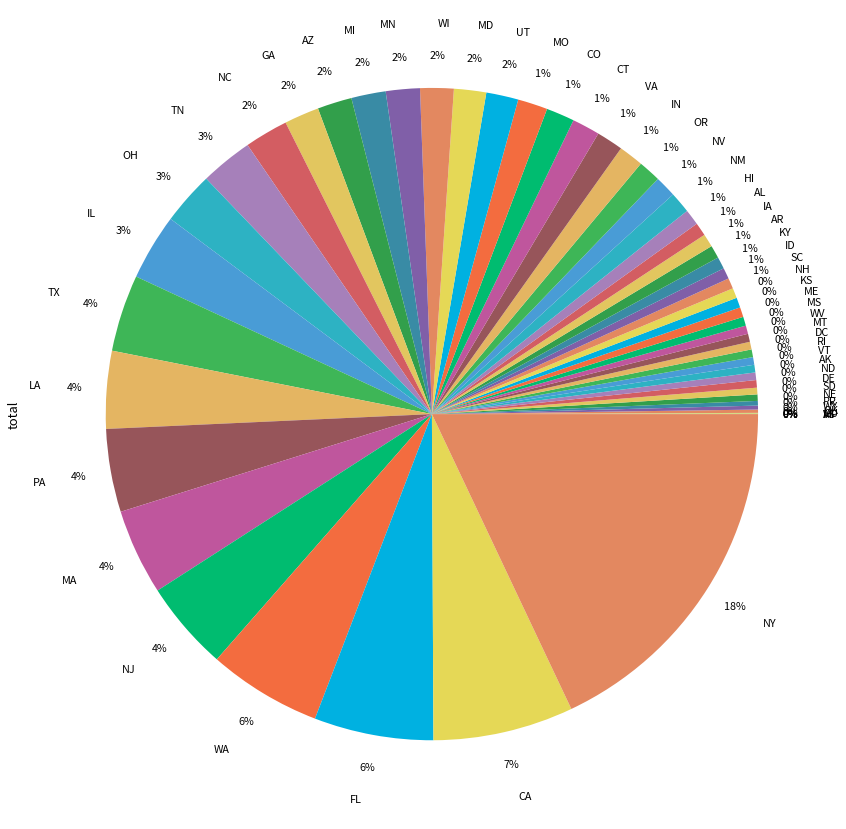

In [106]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

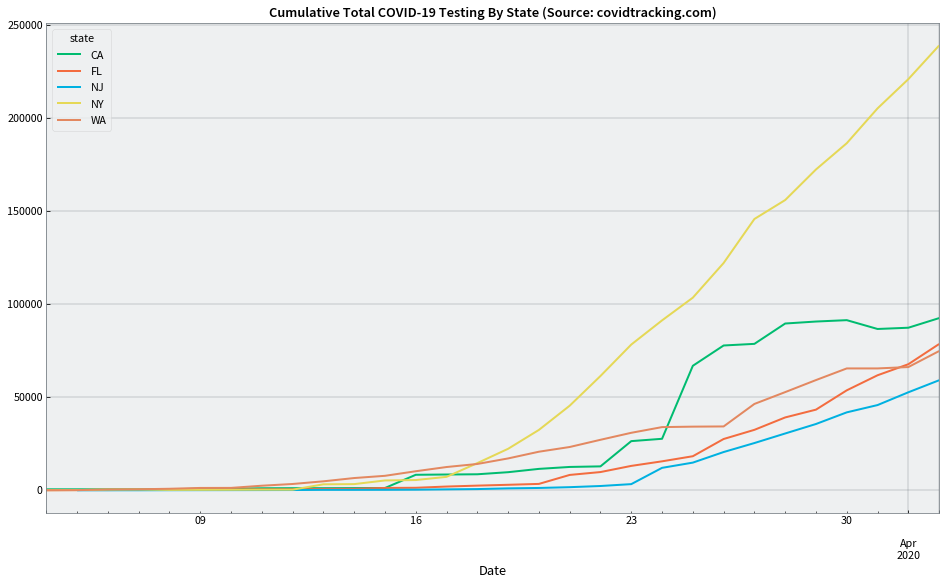

In [107]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

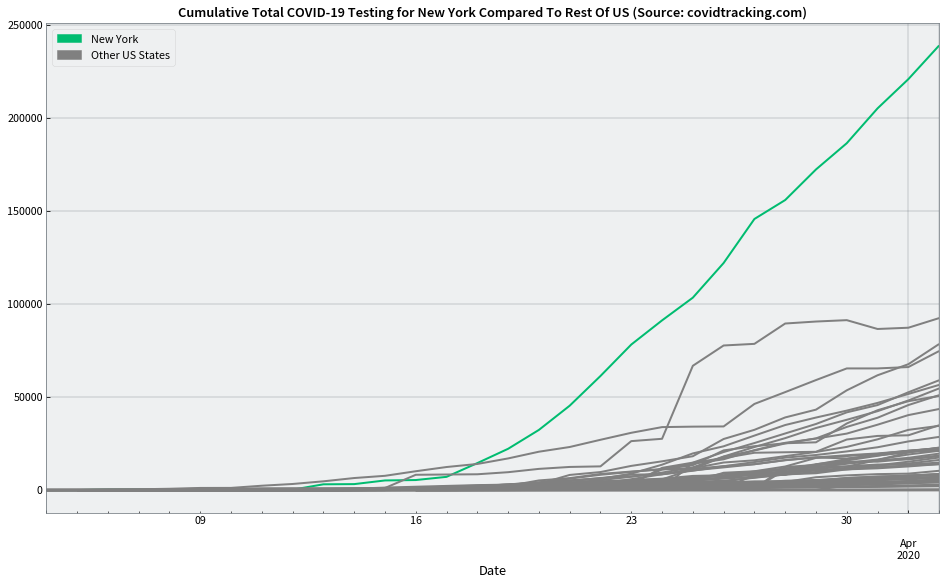

In [108]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

In [ ]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [ ]:
ny_state_hospitalization['Cumulative Hospitalized'] = 

In [ ]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

In [ ]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [ ]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

In [ ]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()